In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import pygrib
import cfgrib

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

# Import data in pandas dataframe

In [2]:
# Load data from MED-R Preindustrial and increased, as before
directory = {'pi' : '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi',
             'incr' : '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr', 
             'curr' : '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/'}

experiments = ['incr', 'pi', 'curr']
cfpf = ['cf', 'pf']  # control and perturbed are treated equally
inits = {'pi' : ['b2nq_2022-02-10', 'b2nn_2022-02-14', 'b2ns_2022-02-16'], 
         'incr' : ['b2nr_2022-02-10', 'b2no_2022-02-14', 'b2nt_2022-02-16'], 
         'curr' : ['1_2022-02-10', '1_2022-02-14', '1_2022-02-16']}  # members for incr and pi runs

In [3]:
# Import full lat, lon values
experiment = 'pi'
init = inits['pi'][0]
cont = 'cf'

lat = xr.open_dataset(os.path.join(directory[experiment],'EU025/sfc',cont,init+'.nc')).latitude.values
lon = xr.open_dataset(os.path.join(directory[experiment],'EU025/sfc',cont,init+'.nc')).longitude.values
 
# Import time steps, NB there are three sets of time steps depending on the initialisation date
fridays = []
for init in inits['pi']:  # time stamps are the same across experiments pi and icnr
    time = xr.open_dataset(os.path.join(directory[experiment],'EU025/sfc',cont,init+'.nc')).time.values
    fridays.append((time >= pd.Timestamp(2022,2,18, 0)) & (time <= pd.Timestamp(2022,2,18, 18)))

# Defining box to analyse winds, south england and wales
lat1 = 52.2
lat2 = 50.3
lon1 = -6
lon2 = 1.3

# Create mask
south_england_dict = {'lat': (lat < lat1) & (lat > lat2), 'lon': (lon < lon2) & (lon > lon1)}
llat, llon = np.meshgrid(lon[south_england_dict['lon']], lat[south_england_dict['lat']])

In [4]:
# empty data frame to be filled later
south_df = pd.DataFrame({'lat': [], 
                         'lon' : [],  
                         'experiment' :[],
                         'cfpf' : [], 
                         'member' : [], 
                         'init' : [],
                         'time' : [],
                         'fg10' : []})

# Fill data frame
members = 50
for experiment in experiments:
    for init in inits[experiment]:
        for cont in cfpf:
            
            # import full data set in file
            data = xr.open_dataset(os.path.join(directory[experiment],'EU025/sfc',cont,init+'.nc'))
            south_england = (data.latitude < lat1) & (data.latitude > lat2) & (data.longitude < lon2) & (data.longitude > lon1) 
            friday = (data.time >= pd.Timestamp(2022,2,18, 0)) & (data.time <= pd.Timestamp(2022,2,18, 18))
            data_filtered = data.where(south_england & friday, drop = True)
            
            # store data in data frame with meta data
            if cont == 'cf':  # distinguish between cfpf because members in pf
                length = len(data_filtered.fg10.values.flatten())
                number_timesteps = len(data_filtered.time.values)
                n_lat = llat.shape[0]
                n_lon = llon.shape[1]
                adding = pd.DataFrame({'lat': np.tile(llat.flatten(), number_timesteps), 
                                        'lon' : np.tile(llon.flatten(), number_timesteps), 
                                        'experiment' : np.tile(experiment, length),
                                        'cfpf' : np.tile(cont, length), 
                                        'member' : np.tile(-1, length), 
                                        'init' : np.tile(init, length), 
                                        'time': np.repeat(data_filtered.time.values.flatten(), n_lat*n_lon), 
                                        'fg10' : data_filtered.fg10.values.flatten()})
                south_df = pd.merge(south_df, adding,
                                    how = 'outer')
            
            elif cont == 'pf': 
                for member in range(members):
                    n_lat = llat.shape[0]
                    n_lon = llon.shape[1]
                    adding = pd.DataFrame({'lat': np.tile(llat.flatten(), number_timesteps), 
                                            'lon' : np.tile(llon.flatten(), number_timesteps), 
                                            'experiment' : np.tile(experiment, length),
                                            'cfpf' : np.tile(cont, length), 
                                            'member' : np.tile(member, length), 
                                            'init' : np.tile(init, length), 
                                            'time': np.repeat(data_filtered.time.values.flatten(), n_lat*n_lon), 
                                            'fg10' : data_filtered.fg10.values[:,member,:,:].flatten()})
                    south_df = pd.merge(south_df, adding,
                                        how = 'outer')


In [5]:
south_df.head()

,lat,lon,experiment,cfpf,member,init,time,fg10
0,-5.75,52.0,incr,cf,-1,b2nr_2022-02-10,2022-02-18,10.980364
1,-5.50,52.0,incr,cf,-1,b2nr_2022-02-10,2022-02-18,10.266060
2,-5.25,52.0,incr,cf,-1,b2nr_2022-02-10,2022-02-18,9.034861
3,-5.00,52.0,incr,cf,-1,b2nr_2022-02-10,2022-02-18,7.949120
4,-4.75,52.0,incr,cf,-1,b2nr_2022-02-10,2022-02-18,7.317068


# Cumulative wind gusts and wind gust histograms

In [6]:
# maximum in time for each grid box
max_time = south_df.groupby(['lat', 'lon', 'init', 'member']).max() # inits are different for pi and incr as well
max_time_mean_latlon = max_time.groupby(['experiment','init', 'member']).mean(numeric_only = True)

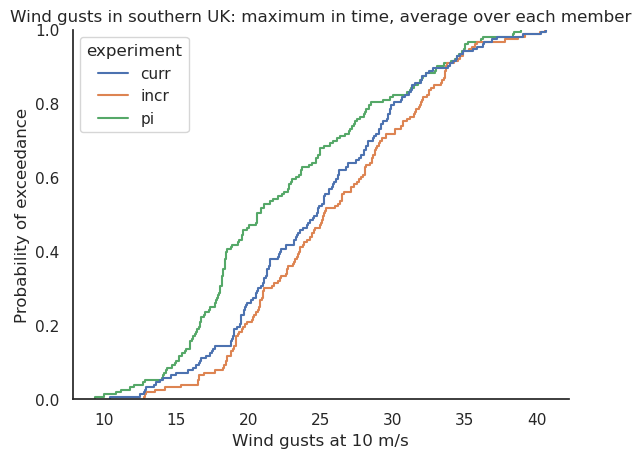

In [7]:
# plot 
sns.ecdfplot(max_time_mean_latlon, x = 'fg10', hue = 'experiment')
plt.xlabel('Wind gusts at 10 m/s')
plt.ylabel('Probability of exceedance')
sns.despine()
plt.title('Wind gusts in southern UK: maximum in time, average over each member')

plt.savefig('figures/03_averaged_cumulative_wind_gusts.pdf')
plt.savefig('figures/03_averaged_cumulative_wind_gusts.png')

# Wind gusts by initialisation date

In [22]:
# Reset index from groupby object to variable 
# https://stackoverflow.com/questions/10373660/converting-a-pandas-groupby-output-from-series-to-dataframe

max_time_mean_latlon_ = max_time_mean_latlon.reset_index()
max_time_mean_latlon_ = max_time_mean_latlon_.assign(init_date = max_time_mean_latlon_.init.str[-10:])

In [33]:
weibull_fits = {}

for experiment in experiments:
    for init in inits[experiment]:
        
        weibull_fits[init] = {'x' : [], 'params' : [], 'rv' : []}
        data = max_time_mean_latlon_[max_time_mean_latlon_.init == init]
        shape, loc, shape1 = stats.weibull_min.fit(data.fg10.values, floc = 0)
        rv_fit = stats.weibull_min(shape, loc, shape1)  # frozen pdf
        weibull_fits[init]['rv'] = rv_fit
        weibull_fits[init]['x'] = np.linspace(rv_fit.ppf(0.01), rv_fit.ppf(0.99), 1000)
        weibull_fits[init]['params'] = [shape, loc, shape1]
        print(weibull_fits[init]['params'])

[3.9613466515062807, 0, 24.558900009938018]
[5.584262130157842, 0, 27.643567507001446]
[6.1983172317314565, 0, 31.798591397618544]
[4.149362655059482, 0, 19.56174816537971]
[4.2114461522252515, 0, 22.802432362024472]
[5.897105265490312, 0, 31.207986031189463]
[4.48544522186217, 0, 22.876465931623137]
[5.4997811434161346, 0, 25.753896222790523]
[5.903540265200852, 0, 31.902156686884595]


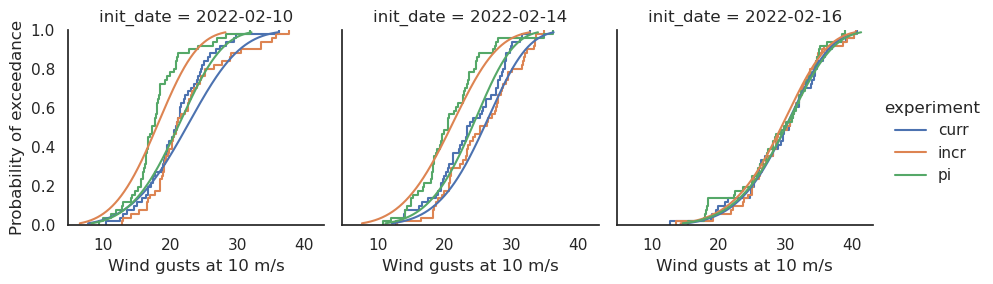

In [43]:
g = sns.FacetGrid(max_time_mean_latlon_, col = 'init_date', hue = 'experiment')
g.map(sns.ecdfplot,'fg10')
g.set_axis_labels("Wind gusts at 10 m/s", "Probability of exceedance")
g.add_legend()
for i, ax in enumerate(g.axes_dict.values()):
    for experiment in experiments:
        init = inits[experiment][i]
        x = weibull_fits[init]['x']
        rv = weibull_fits[init]['rv']
        ax.plot(x, rv.cdf(x))
sns.despine()

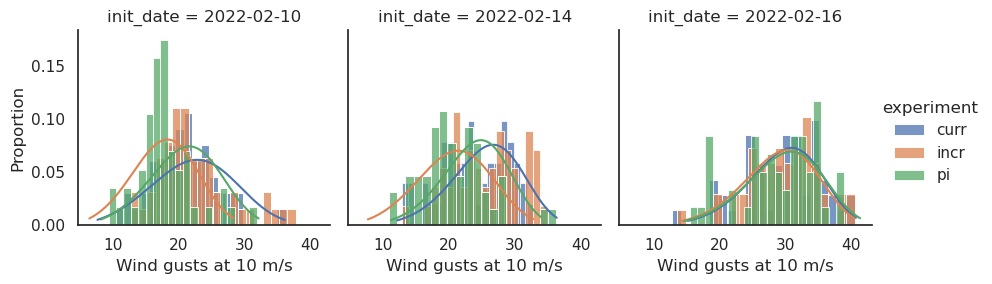

In [39]:
g = sns.FacetGrid(max_time_mean_latlon_, col = 'init_date', hue = 'experiment')
g.map(sns.histplot,'fg10', bins = 20, stat='density')
g.set_axis_labels("Wind gusts at 10 m/s", "Proportion")
for i, ax in enumerate(g.axes_dict.values()):
    for experiment in experiments:
        init = inits[experiment][i]
        x = weibull_fits[init]['x']
        rv = weibull_fits[init]['rv']
        ax.plot(x, rv.pdf(x))
g.add_legend()

sns.despine()